# Imports

In [1]:
from library.dataPreprocessLib import *
from library.resultsLib import *
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import os

# Data Preprocessing

## Feature Selection and Loading Data

In [84]:
#name = "prantika_bus_stand"
#name = "junction_mall"
#name = "54ft_road"
#name = "dvc_more"
name = "station"

In [85]:
parent_dir = r"../data/54ft/"
train_df_name = r"54ft_train.csv"
test_df_name = f"{name}_test_split.csv"

In [86]:
poi_column = 'Is_Turn'
output_result_filename = f"{poi_column}_test_result_{name}_zone.csv"

In [87]:
#feature # binding
F=\
    {1:'stay_duration', #f1
     2:'mfcc0',3:'mfcc1',4:'mfcc2',5:'mfcc3',6:'mfcc4', #f2,f3,f4,f5,f6
     7:'wifi_count', 8:'edge_wifi_count', #f7,f8
     9:'RSI', #f9
     10:'human_made', 11:'natural_land',12:'road_exist_percent',13:'highly_populated_poi_exist'#f10,f11,f12,f13
    }



feature_names=[F[e] for e in [10,12,11,1,8,9]]

### Training Data

In [88]:
train_csv_df = pd.read_csv(os.path.join(parent_dir, train_df_name))
train_df = train_csv_df[feature_names+[poi_column]]
train_df.head()

,human_made,road_exist_percent,natural_land,stay_duration,edge_wifi_count,RSI,Is_Turn
0,0.111232,0.251963,0.636805,6,0.000000,0.000000,0
1,0.124869,0.208544,0.666587,10,0.015468,2.715045,0
2,0.100360,0.155972,0.743668,130,0.027800,2.422751,1
3,0.100911,0.169076,0.730013,13,0.000000,3.040420,0
4,0.117394,0.183064,0.487688,9,0.002818,1.780860,1


### Testing Data

In [89]:
test_csv_df = pd.read_csv(os.path.join(parent_dir, test_df_name))
test_df = test_csv_df[feature_names+[poi_column]]
test_df.head()

,human_made,road_exist_percent,natural_land,stay_duration,edge_wifi_count,RSI,Is_Turn
0,0.122769,0.182053,0.692291,105,0.000000,0.000000,1
1,0.107162,0.125955,0.766882,12,0.024291,1.289747,0
2,0.160116,0.142546,0.697338,95,0.000000,32.959722,0
3,0.112501,0.175124,0.700820,102,0.012752,4.292388,1
4,0.124594,0.144481,0.730924,4,0.007056,1.737973,0


### Seperating target column and input columns

In [90]:
X = train_df[feature_names].copy()
y = train_df[poi_column].copy()

## Using SMOTE

In [91]:
smote = SMOTE()

In [92]:
X_resampled, y_resampled = smote.fit_sample(X, y)
print(X.shape)
print(y.shape)
print(X_resampled.shape)
print(y_resampled.shape)

(2480, 6)
(2480,)
(3642, 6)
(3642,)


## Categorical data Transformation

### For train data

In [93]:
train_data = X_resampled.copy()
train_labels = y_resampled.copy()

### For test data

In [94]:
test_data = test_df[feature_names].values
test_labels = test_df[poi_column].values

# Training

In [95]:
model = RandomForestClassifier(n_estimators=20,max_depth=8)
model.fit(train_data, train_labels)
train_predictions = model.predict(train_data) # for training performance stat

# Testing

In [96]:
assert test_data.shape[1] == train_data.shape[1]
test_predictions = model.predict(test_data)

# Performance Stat

## Training Performance

In [97]:
get_performance_stats("train", train_labels, train_predictions)

For train: 
	Accuracy: 0.9137836353651839
	Precision: 0.9166868360979878
	Recall: 0.9137836353651839
	F1 score: 0.9136331985505691
              precision    recall  f1-score   support

           0       0.95      0.87      0.91      1821
           1       0.88      0.96      0.92      1821

    accuracy                           0.91      3642
   macro avg       0.92      0.91      0.91      3642
weighted avg       0.92      0.91      0.91      3642



## Testing Performance

In [98]:
get_performance_stats("test", test_labels, test_predictions)

For test: 
	Accuracy: 0.9027777777777778
	Precision: 0.915204678362573
	Recall: 0.9027777777777778
	F1 score: 0.9069325735992402
              precision    recall  f1-score   support

           0       0.96      0.92      0.94        60
           1       0.67      0.83      0.74        12

    accuracy                           0.90        72
   macro avg       0.82      0.88      0.84        72
weighted avg       0.92      0.90      0.91        72



### Confusion Matrix

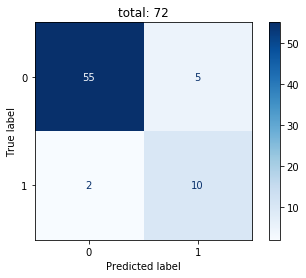

In [99]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
disp = plot_confusion_matrix(model, test_data, test_labels, cmap=plt.cm.Blues)
disp.ax_.set_title(f'total: {len(test_data)}')
plt.show()

### Check & Save Predicitons

In [100]:
result_df = form_result_df(test_csv_df, test_predictions, poi_column)
result_df.head()

,instance_date,instance_start_time,instance_end_time,Prediction Is_Turn
0,09/14/2019,12:04:16,12:06:01,1
1,09/14/2019,12:06:36,12:06:47,0
2,09/14/2019,16:39:20,16:40:54,0
3,09/14/2019,16:45:03,16:46:45,1
4,09/14/2019,11:39:46,11:39:49,0


In [101]:
result_df.to_csv(os.path.join(parent_dir, output_result_filename), index=False)

In [102]:
test_labels

array([1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0], dtype=int64)

In [103]:
test_predictions

array([1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0], dtype=int64)